### Importing the data

In [11]:
import pandas as pd

df = pd.read_csv('data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850


In [12]:
df.shape

(383842, 7)

### Data Preprocessing

In [13]:
# Check for Null Values
df.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
dtype: bool

In [14]:
# Convert InvoiceDate into the format of 'yyyy-mm-dd'
import datetime as dt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = [x.date() for x in df['InvoiceDate']]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850


### Calculate Recency, Frequency and MonetaryValue

- **Recency**: Days between the snapshot date (last order date from the data set + 1) and the customer's most recent order date
- **Frequency**: Number of purchases made by the customer
- **MonetaryValue**: Total spend by the customer

In [15]:
# Calculate the spend for each transaction
df['Spend'] = df['UnitPrice'] * df['Quantity']
df = df[['CustomerID','InvoiceDate', 'InvoiceNo', 'Spend']]
df.head()

,CustomerID,InvoiceDate,InvoiceNo,Spend
0,17850,2010-12-01,536365,15.30
1,17850,2010-12-01,536365,20.34
2,17850,2010-12-01,536365,22.00
3,17850,2010-12-01,536365,20.34
4,17850,2010-12-01,536365,20.34


In [17]:
# Create snapshot_date
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(snapshot_date)

2011-12-10


In [18]:
# Calculate Recency, Frequency and MonetaryValue for each customer

dfc = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Spend': 'sum'
})

# Rename columns for easier interpretation
dfc.rename(columns = 
           {'InvoiceDate': 'Recency',
            'InvoiceNo': 'Frequency',
            'Spend': 'MonetaryValue'}, inplace=True)

dfc.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40
12352,37,85,2506.04


### Preparing Data for K-means Clusterings

Before we apply K-means clusterings, there are several input data requirements we have to consider:
- **Symmetric distribution** of variables (not skewed)
- All variables have the **same mean**
- All variables have the **same variance**

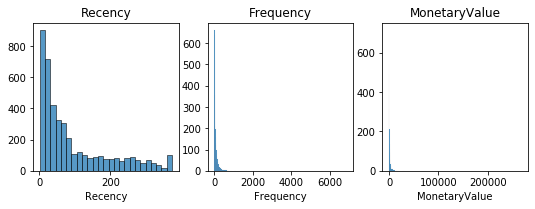

In [19]:
#Plot each variables and check if the distribution is skewed.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
sns.histplot(dfc['Recency'])
plt.title('Recency')
plt.ylabel('')

plt.subplot(2,4,2)
sns.histplot(dfc['Frequency'])
plt.title('Frequency')
plt.ylabel('')

plt.subplot(2,4,3)
sns.histplot(dfc['MonetaryValue'])
plt.title('MonetaryValue')
plt.ylabel('')

plt.show()

Notice that all three variables are right skewed and so I applied log transformation to manage the skewness.

In [20]:
import numpy as np

dfc['Recency'] = np.log(dfc['Recency'])
dfc['Frequency'] = np.log(dfc['Frequency'])
dfc['MonetaryValue'] = np.log(dfc['MonetaryValue'])

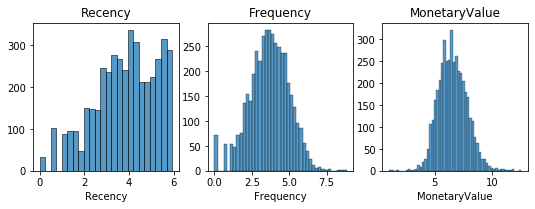

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
sns.histplot(dfc['Recency'])
plt.title('Recency')
plt.ylabel('')

plt.subplot(2,4,2)
sns.histplot(dfc['Frequency'])
plt.title('Frequency')
plt.ylabel('')

plt.subplot(2,4,3)
sns.histplot(dfc['MonetaryValue'])
plt.title('MonetaryValue')
plt.ylabel('')

plt.show()

In [22]:
dfc.describe()

,Recency,Frequency,MonetaryValue
count,4333.000000,4333.000000,4333.000000
mean,3.803294,3.659633,6.572789
std,1.381691,1.315309,1.248713
min,0.000000,0.000000,1.064711
25%,2.890372,2.833213,5.725087
50%,3.931826,3.688879,6.502940
75%,4.962845,4.574711,7.399802
max,5.924256,8.838407,12.498230


The variables have different means and standard deviations, so I used the StandardScaler to normalize the data for Kmeans to work best.

In [23]:
#Center and scale with StandardScaler()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfc)
dfc_normalized = scaler.transform(dfc)
dfc_normalized = pd.DataFrame(dfc_normalized, index=dfc.index, columns=dfc.columns)
dfc_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4333.00,4333.00,4333.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.75,-2.78,-4.41
25%,-0.66,-0.63,-0.68
50%,0.09,0.02,-0.06
75%,0.84,0.70,0.66
max,1.54,3.94,4.75


StandardScaler() standardizes the data by removing the mean and scaling to unit varaince.

### Choosing the number of clusters

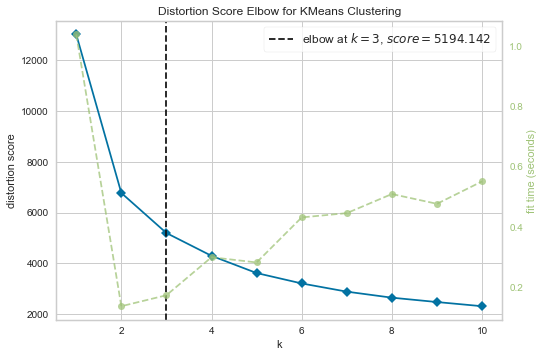

In [24]:
# Elbow method / SSE Plot

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=1)
visualizer = KElbowVisualizer(km, k=(1,11))
 
visualizer.fit(dfc_normalized)        # Fit the data to the visualizer
visualizer.show() 

As per the plot, n_clusters = 3 represents the elbow you start seeing that the line starts looking linear.

### Run KMeans with 3 clusters

In [25]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(dfc_normalized)
labels = kmeans.fit_predict(dfc_normalized)

# Create a pandas DataFrame by adding a cluster label column
dfc_cluster = dfc.assign(Cluster=labels)
dfc_cluster.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,1.098612,5.204007,8.368693,2
12348,4.330733,3.433987,7.494007,1
12349,2.944439,4.290459,7.471676,1
12350,5.739793,2.833213,5.812338,0
12352,3.610918,4.442651,7.826459,1


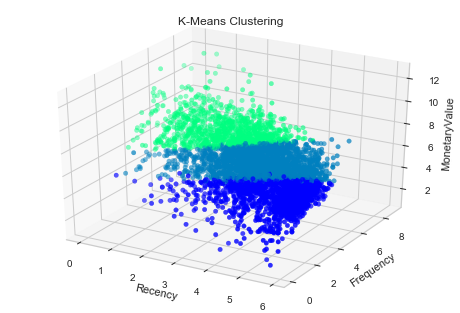

In [26]:
#Plot the clusters obtained using k means

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('K-Means Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

ax.scatter(dfc_cluster['Recency'],dfc_cluster['Frequency'], dfc_cluster['MonetaryValue'],c=labels,cmap='winter')
plt.show()

In [27]:
dfc_cluster.groupby('Cluster').agg({
    'Recency':['mean','min', 'max'],
    'Frequency':['mean','min', 'max'],
    'MonetaryValue':['mean','min', 'max', 'count']
}).round(2)

Recency             Frequency             MonetaryValue              \
           mean   min   max      mean   min   max          mean   min   max   
Cluster                                                                       
0          4.88  0.69  5.92      2.34  0.00  4.33          5.39  1.06   7.6   
1          3.81  0.69  5.92      3.89  1.10  6.13          6.68  4.74   9.2   
2          2.23  0.00  4.82      5.16  2.71  8.84          8.09  6.14  12.5   

               
        count  
Cluster        
0        1459  
1        1870  
2        1004

From the statistics summary:<br>
Cluster 2 is the most valuable group of customers with highest mean Frequency (purchase most often) and mean MonetaryValue, lowest mean Recency (has recently purchase from the company). <br>
Cluster 0 is the worst group with lowest Frequency and MonetaryValue and highest Recency.